## Objetivo
Avaliar  a detecção de falha por meio do valor eficaz (RMS) da velocidade segundo norma ABNT

# Níveis gerais de vibração
## Desbalanceamento

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data.csv')
print('Amostras: {} \nColunas: {}'.format(df.shape[0], df.shape[1]))

Amostras: 880 
Colunas: 58


In [3]:
def filter_defect(df, defeito):
    # separa apenas amostras com de'feito'
    filtered_df =  df.query("defeito == '{}' or defeito == 'normal'".format(defeito))
    filtered_df.pop('defeito')
    # separa apenas as colunas com RMS da velocidade
    filtered_df = filtered_df[[
        'severidade',   'fundamental', 
         'ax1_vel_rms',  
         'ax2_vel_rms', 
        'rad1_vel_rms', 
        'rad2_vel_rms', 
         'tg1_vel_rms',  
         'tg2_vel_rms' 
    ]]
    # simplifica o nome dos eixos
    filtered_df = filtered_df.rename(columns={
         'ax1_vel_rms': 'ax1',  
         'ax2_vel_rms': 'ax2', 
        'rad1_vel_rms': 'rad1', 
        'rad2_vel_rms': 'rad2', 
         'tg1_vel_rms': 'tg1',  
         'tg2_vel_rms': 'tg2',
         'ax1_rms': 'ax1',  
         'ax2_rms': 'ax2', 
        'rad1_rms': 'rad1', 
        'rad2_rms': 'rad2', 
         'tg1_rms': 'tg1',  
         'tg2_rms': 'tg2',
    })

    return filtered_df

df_desbal = filter_defect(df, 'desbalanceamento')
df_desbal

severidade  fundamental       ax1       ax2      rad1      rad2  \
498        10.0      13.6272  3.709297  1.001809  0.921058  0.210116   
499        10.0      14.2284  3.924583  1.033236  1.021624  0.218205   
500        10.0      15.4308  3.378807  1.113301  1.058142  0.219163   
501        10.0      16.2324  2.950474  1.035870  1.035508  0.202693   
502        10.0      16.8336  3.287712  0.869502  1.082875  0.178001   
..          ...          ...       ...       ...       ...       ...   
875         0.0      56.7132  1.362673  0.657733  2.008915  0.130578   
876         0.0      57.5148  1.584103  0.480961  2.029893  0.099970   
877         0.0      58.3164  1.745069  0.399143  2.111434  0.098966   
878         0.0      59.1180  1.746503  0.339588  2.174394  0.089324   
879         0.0      60.1200  1.986275  0.315933  2.227596  0.082059   

          tg1       tg2  
498  0.160228  4.237119  
499  0.179018  4.583939  
500  0.231928  3.498109  
501  0.244354  2.930913  
502  0.317970  3.090470  
..        ...       ...  
875  0.527572  0.981479  
876  0.558485  0.969856  
877  0.534440  1.029314  
878  0.525599  1.074776  
879  0.550639  1.045629  

[382 rows x 8 columns]

In [4]:
VALUE = 'vibração RMS (mm/s)'
ROTACAO = 'rotação (Hz)'
DESBALANCEAMENTO = 'desbalanceamento (g)'

def select_max(df_filtered):
    # encontra o valor máximo entre todos os RMS
    max_rms = df_filtered.drop(['fundamental', 'severidade'], axis=1).max(axis=1)

    # revela o eixo onde há o maior RMS
    eixo = []
    for i in df_filtered.index:
        for col in df_filtered.columns:
            if df_filtered.loc[i, col] == max_rms[i]:
                eixo.append(col) 

    # cria o novo Dataframe com os máximos
    df_max = df_filtered[['severidade', 'fundamental']]
    df_max.rename(columns={'fundamental': ROTACAO}, inplace=True)
    df_max['eixo'] = eixo
    df_max[VALUE] = max_rms

    return df_max


df_desbal_max = select_max(df_desbal)
df_desbal_max.rename(columns={'severidade': DESBALANCEAMENTO}, inplace=True)

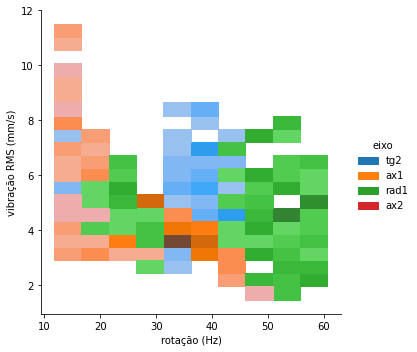

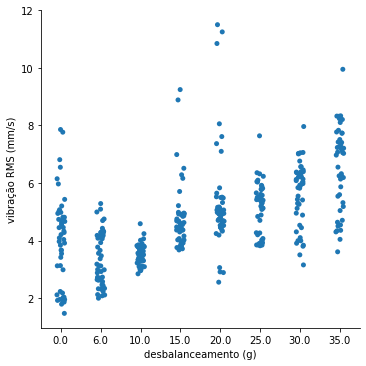

In [5]:
sns.displot(data=df_desbal_max, hue='eixo', y=VALUE, x=ROTACAO);
sns.catplot(data=df_desbal_max, y=VALUE, x=DESBALANCEAMENTO, color='tab:blue');

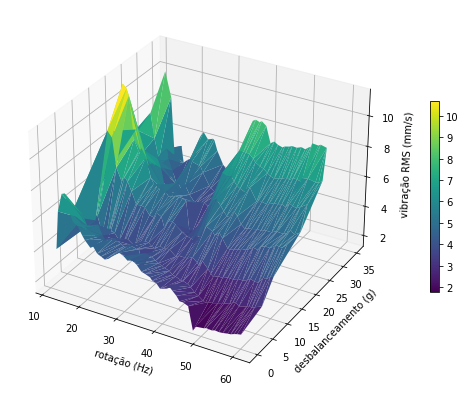

In [6]:
from mpl_toolkits import mplot3d

def plot_surface(df_max, defect_name, fig=None, ax=None):
    # Make the plot

    figura_solo=False

    if ax is None:
        fig = plt.figure(figsize=(15,7))
        ax = fig.add_subplot(projection='3d')
        figura_solo=True

    surf = ax.plot_trisurf(
        df_max[ROTACAO], df_max[defect_name], df_max[VALUE], 
        cmap=plt.cm.viridis, linewidth=0.1
    )
    ax.set_xlabel(ROTACAO)
    ax.set_zlabel(VALUE);

    # to Add a color bar which maps values to colors.
    if figura_solo:
        fig.colorbar(surf, ax=ax, shrink=0.5)
        ax.set_ylabel(defect_name)
    else:
        ax.set_ylabel(defect_name)
        fig.colorbar(surf, ax=ax, shrink=0.2)

plot_surface(df_desbal_max, DESBALANCEAMENTO)

Nível de vibração RMS


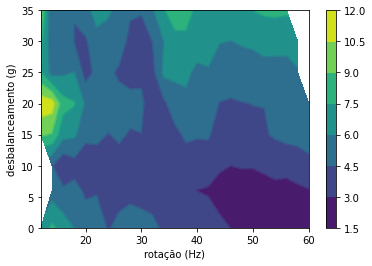

In [7]:
def plota_niveis(df_max, defect_name, fig=None, ax=None):
    df_pivot = df_max.drop(['eixo'], axis=1).copy(deep=True)
    df_pivot[ROTACAO] = df_pivot[ROTACAO].apply(round)//2*2
    df_pivot = df_pivot.groupby([ROTACAO, defect_name]).max()
    df_pivot = df_pivot.reset_index()
    df_pivot = df_pivot.pivot(index=ROTACAO, columns=defect_name, values=VALUE)


    X, Y = np.meshgrid(df_pivot.index, df_pivot.columns)
    Z= df_pivot.T

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot()
        
    CS = ax.contour(X, Y, Z, levels=8)
    cp = ax.contourf(X, Y, Z)
    fig.colorbar(cp, ax=ax)
    ax.set_xlabel(ROTACAO)
    ax.set_ylabel(defect_name)
    # ax.clabel(CS, inline=1, fontsize=10)
    print('Nível de vibração RMS');

plota_niveis(df_desbal_max, DESBALANCEAMENTO)

Nível de vibração RMS


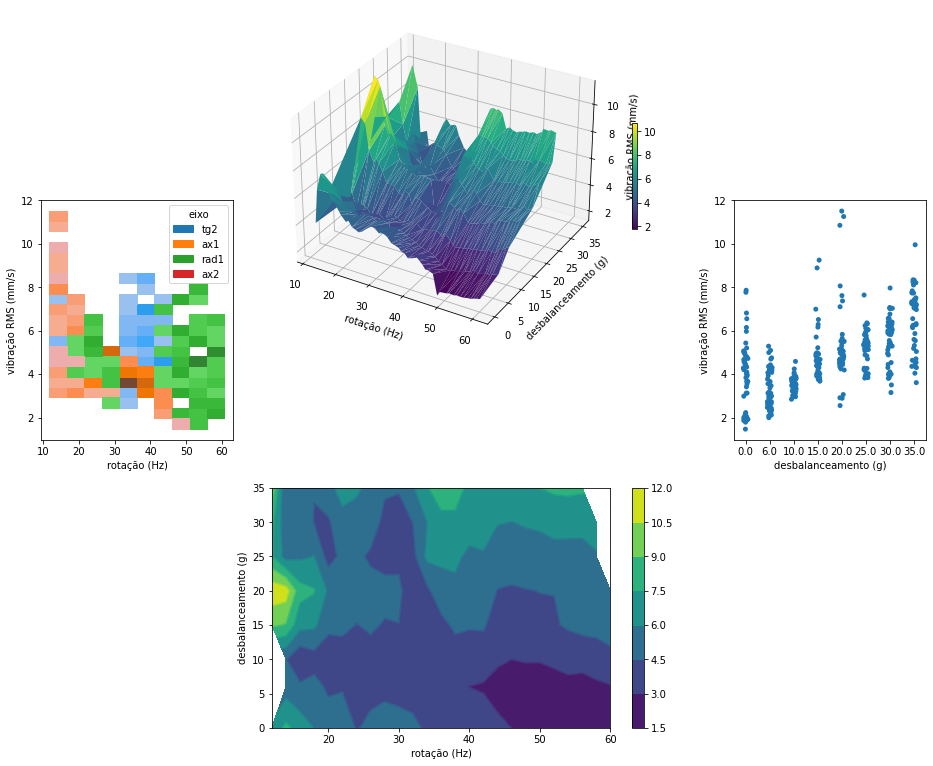

In [11]:
from mpl_toolkits import mplot3d

def plot_conjunto(df_max, defect_name):
    # Make the plot
    fig = plt.figure(figsize=(20,15))

    ax = fig.add_subplot(3, 5, (2,8), projection='3d')
    plot_surface(df_max, defect_name, fig, ax=ax)

    ax = fig.add_subplot(3, 5, 6)
    sns.histplot(data=df_max, hue='eixo', y=VALUE, x=ROTACAO, ax=ax);

    ax = fig.add_subplot(3, 5, 9)
    sns.stripplot(data=df_max, y=VALUE, x=defect_name, color='tab:blue', ax=ax);

    ax = fig.add_subplot(3, 5, (12,13))
    plota_niveis(df_max, defect_name, fig, ax)


plot_conjunto(df_desbal_max, DESBALANCEAMENTO)

# Desalinhamentos

## Vertical

In [27]:
df_des_ver = filter_defect(df, 'desalinhamento_vertical')
df_des_ver_max = select_max(df_des_ver)

DESALINHAMENTO_VERTICAL = 'desalinhamento vertical (mm)' 
df_des_ver_max.rename(columns={'severidade': DESALINHAMENTO_VERTICAL}, inplace=True)
df_des_ver_max

desalinhamento vertical (mm)  rotação (Hz)  eixo  vibração RMS (mm/s)
197                          0.51       12.2244   ax2             9.169538
198                          0.51       12.8256   ax2             6.954411
199                          0.51       14.6292   ax1             5.835915
200                          0.51       15.8316   ax1             4.914379
201                          0.51       16.6332   ax1             5.453138
..                            ...           ...   ...                  ...
875                          0.00       56.7132  rad1             2.008915
876                          0.00       57.5148  rad1             2.029893
877                          0.00       58.3164  rad1             2.111434
878                          0.00       59.1180  rad1             2.174394
879                          0.00       60.1200  rad1             2.227596

[350 rows x 4 columns]

Nível de vibração RMS


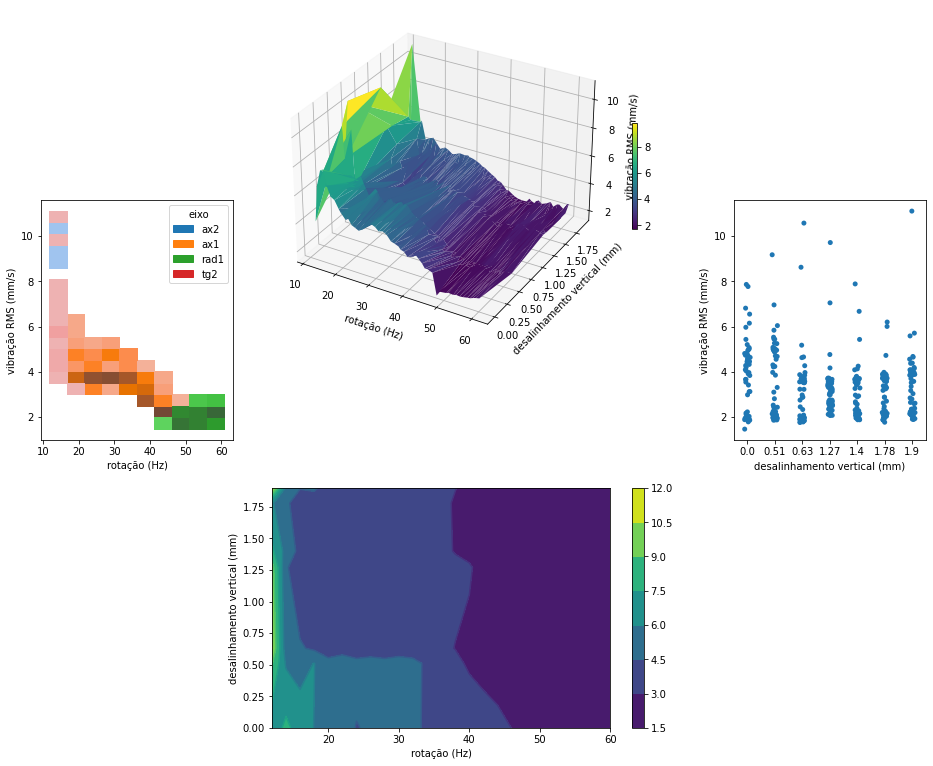

In [12]:
plot_conjunto(df_des_ver_max, DESALINHAMENTO_VERTICAL)

Notamos que a vibração axial acaba ofuscando os demais eixos. Por isso repetiremos a análise para eixos significativos.

### tg2

In [13]:
df_des_ver_max_TG2 = select_max(df_des_ver[['fundamental', 'severidade', 'tg2']])
df_des_ver_max_TG2.rename(columns={'severidade': DESALINHAMENTO_VERTICAL}, inplace=True)

Nível de vibração RMS


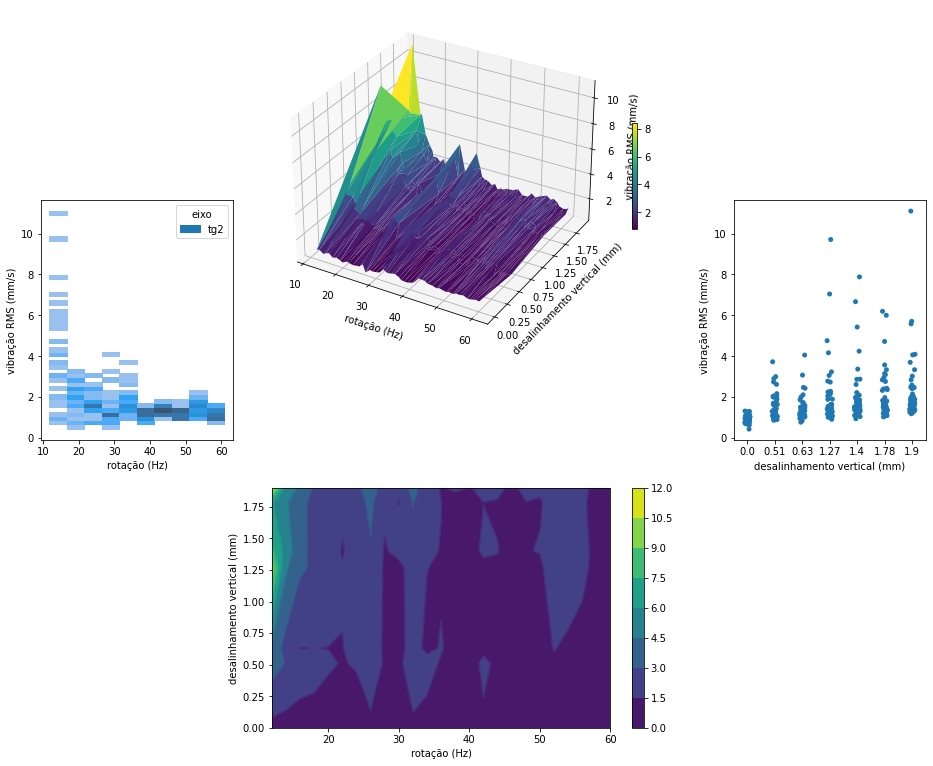

In [14]:
plot_conjunto(df_des_ver_max_TG, DESALINHAMENTO_VERTICAL)

### Tangente 1

In [15]:
df_des_ver_max_TG1 = select_max(df_des_ver[['fundamental', 'severidade', 'tg1']])
df_des_ver_max_TG1.rename(columns={'severidade': DESALINHAMENTO_VERTICAL}, inplace=True)

Nível de vibração RMS


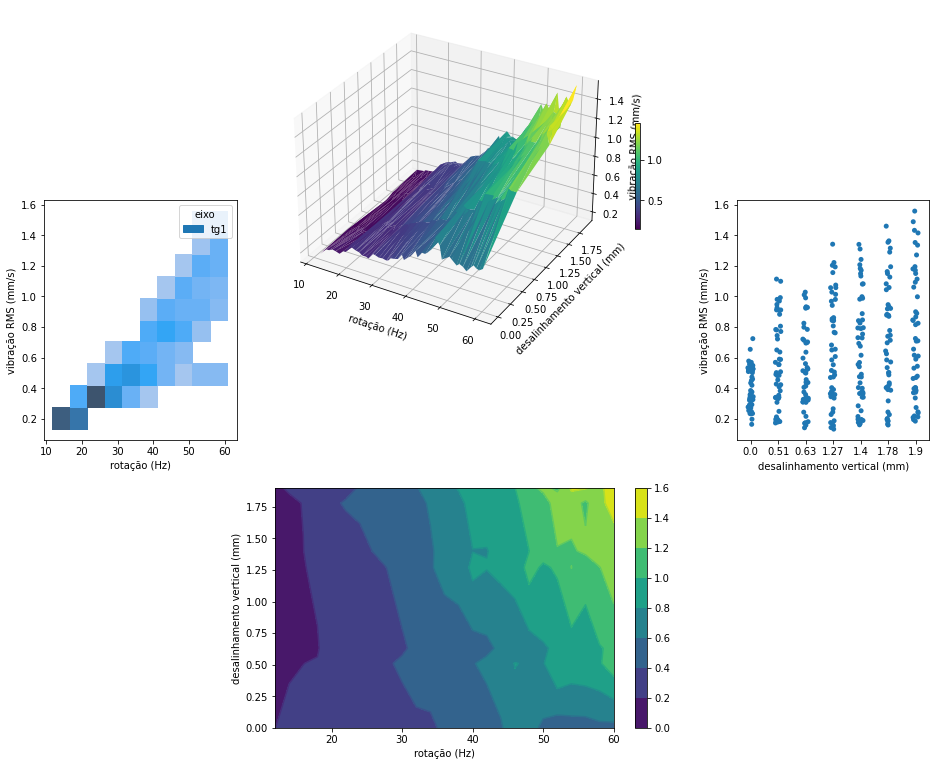

In [16]:
plot_conjunto(df_des_ver_max_TG, DESALINHAMENTO_VERTICAL)

## Horizontal

In [17]:
df_des_hor = filter_defect(df, 'desalinhamento_horizontal')
df_des_hor_max = select_max(df_des_hor)

DESALINHAMENTO_HORIZONTAL = 'desalinhamento horizontal (mm)' 
df_des_hor_max.rename(columns={'severidade': DESALINHAMENTO_HORIZONTAL}, inplace=True)
df_des_hor_max

desalinhamento horizontal (mm)  rotação (Hz)  eixo  vibração RMS (mm/s)
0                               0.5       12.0240   ax2             6.757012
1                               0.5       13.2264   ax2             5.381334
2                               0.5       14.2284   ax2             5.085044
3                               0.5       15.0300   ax2             5.342766
4                               0.5       16.0320   ax2             5.004467
..                              ...           ...   ...                  ...
875                             0.0       56.7132  rad1             2.008915
876                             0.0       57.5148  rad1             2.029893
877                             0.0       58.3164  rad1             2.111434
878                             0.0       59.1180  rad1             2.174394
879                             0.0       60.1200  rad1             2.227596

[246 rows x 4 columns]

Nível de vibração RMS


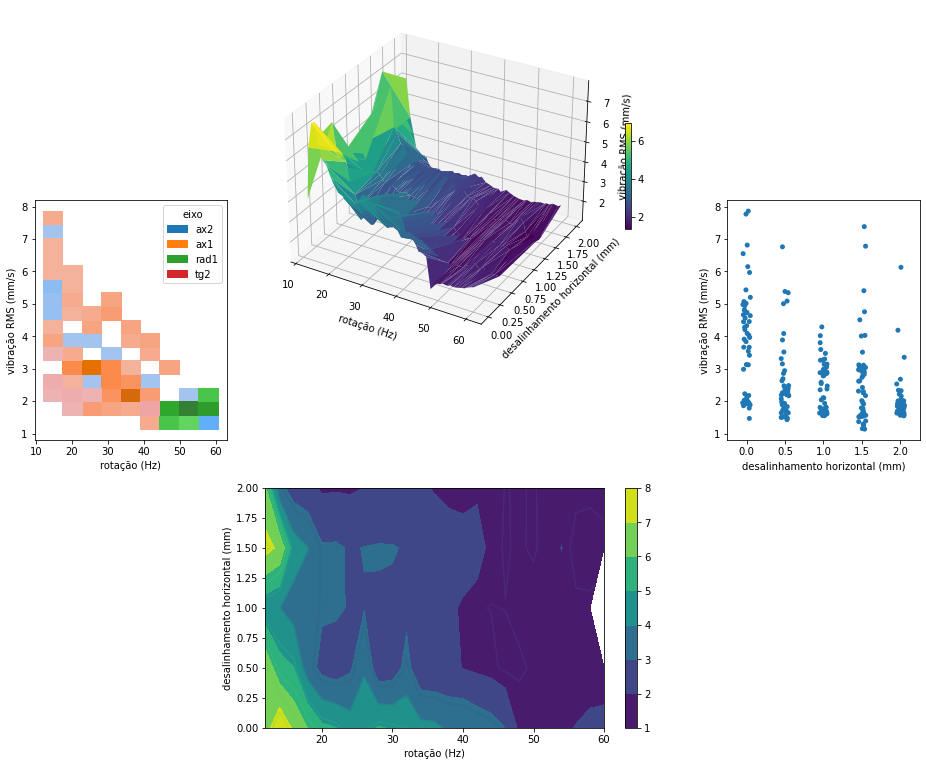

In [18]:
plot_conjunto(df_des_hor_max, DESALINHAMENTO_HORIZONTAL)

# Adequação à norma ABNT NBR 10082

* **Zona A**: valores de vibração recomendados para máquinas novas ou recentemente comissionadas;

* **Zona B**:  consideradas  aceitáveis para operação contínua para longo período de operação, sem restrição;

* **Zona C**:  consideradas insatisfatórias para a operação contínua por um longo período. Geralmente, podem continuar operando por um período limitado de tempo e deve-se programar sua correção;

* **Zona D**: indicam possibilidades de danos em curto prazo

In [54]:
# referência: http://www.brascopper.ind.br/dgq/Sistema%20de%20Gest%C3%A3o%20da%20Qualidade/4%20-%20Contexto%20da%20Organiza%C3%A7%C3%A3o/4.4%20-%20SGQ%20e%20seus%20Processos/Normas/NBR/NBR10082%20-%202011%20-%20Ensaio%20n%C3%A3o%20destrutivo%20-%20An%C3%A1lise%20de%20vibra%C3%A7%C3%B5es.pdf

def zona_NBR10082(valor_eficaz):
    # considerando equipamento Grupo II, suporte flexível
    if valor_eficaz < 2.8:
        return 'A'
    elif valor_eficaz < 4.5:
        return 'B'
    elif valor_eficaz < 7.1:
        return 'C'
    else:
        return 'D'

def zona_ISO10816(valor_eficaz):
    # considerando equipamento classe 1 (máquinas pequenas)
    if valor_eficaz < 1.12:
        return 'A'
    elif valor_eficaz < 2.8:
        return 'B'
    elif valor_eficaz < 7.1:
        return 'C'
    else:
        return 'D'

# definição de cores para cada zona
paleta = {'A':'tab:green', 'B':'tab:olive', 'C':'tab:orange', 'D':'tab:red'}

# indexadores
names = ['Desbalanceamento', 'Desalinhamento vertical', 'Desalinhamento horizontal']
dataframes = [df_desbal_max, df_des_ver_max, df_des_hor_max]

# aplica a norma nos valores RMS
for defect_df in dataframes:
    defect_df['zona'] = defect_df[VALUE].apply(zona_NBR10082)
    defect_df.sort_values('zona', inplace=True, ascending=True)

# reúne dataframes
df_merged = pd.concat(dataframes, keys=names, names=['defeito', 'index']).reset_index()
df_merged.sort_values('zona', inplace=True, ascending=True)

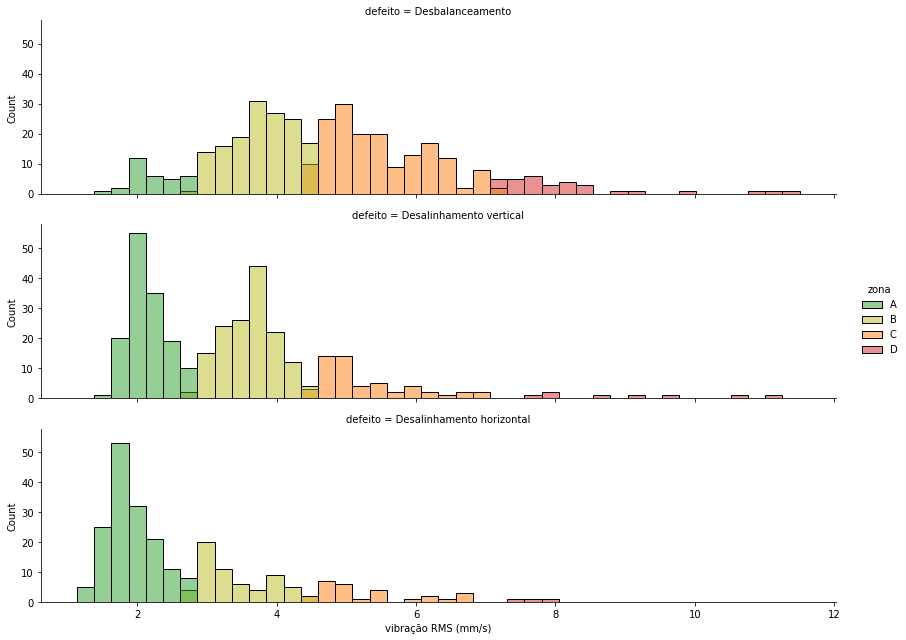

In [55]:
sns.displot(data=df_merged, x=VALUE, hue='zona', palette=paleta, row='defeito', aspect=4, height=3, bins=42);

## Desbalanceamento

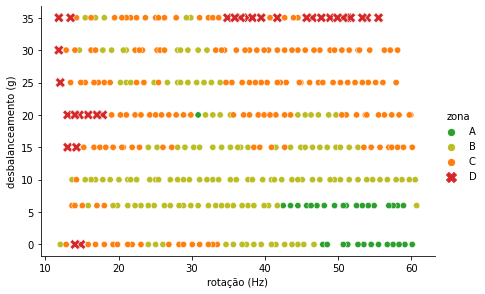

In [56]:
sns.relplot(
    data=df_desbal_max, height=4, aspect=1.5,
    y=DESBALANCEAMENTO, x=ROTACAO, size='zona', sizes=[40, 40, 40, 100], markers='oooX', style='zona',
    hue='zona', palette=paleta
);  

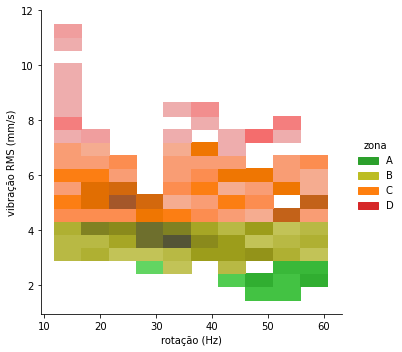

In [57]:
sns.displot(data=df_desbal_max, hue='zona', y=VALUE, x=ROTACAO, palette=paleta);

## Desalinhamento Vertical

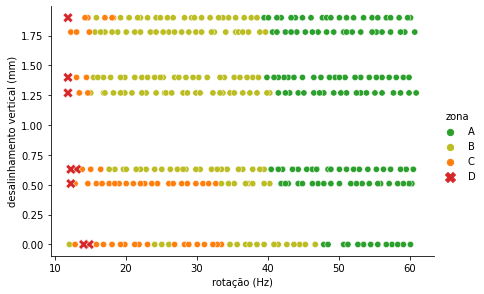

In [58]:
sns.relplot(
    data=df_des_ver_max, height=4, aspect=1.5,
    y=DESALINHAMENTO_VERTICAL, x=ROTACAO, size='zona', sizes=[40, 40, 40, 100], markers='oooX', style='zona',
    hue='zona', palette=paleta
);  

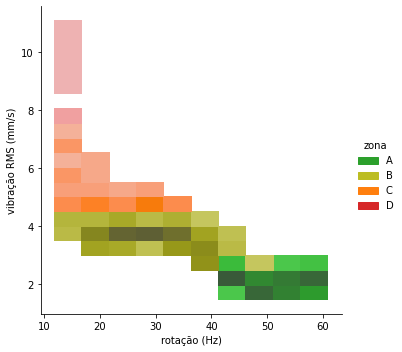

In [59]:
sns.displot(data=df_des_ver_max, hue='zona', y=VALUE, x=ROTACAO, palette=paleta);

## Desalinhamento horizontal

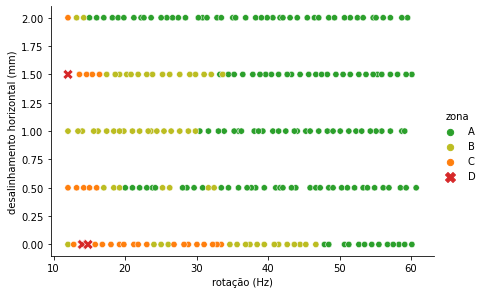

In [60]:
sns.relplot(
    data=df_des_hor_max, height=4, aspect=1.5,
    y=DESALINHAMENTO_HORIZONTAL, x=ROTACAO, size='zona', sizes=[40, 40, 40, 100], markers='oooX', style='zona',
    hue='zona', palette=paleta
);  

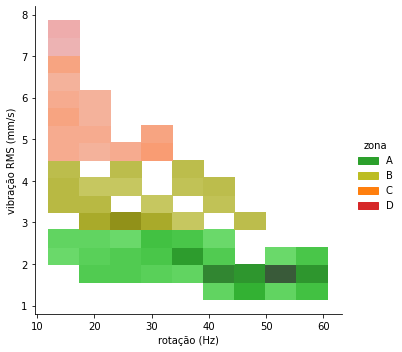

In [61]:
sns.displot(data=df_des_hor_max, hue='zona', y=VALUE, x=ROTACAO, palette=paleta);

# Hipótese de ressonância a ~12 Hz

In [62]:
# DADOS FORNECIDOS
L = 390e-3   # distância entre mancais (390 mm)
d =  16e-3   # diâmetro do eixo (16 mm)
D = 15.24e-2 # diâmetro do rotor (15.24 cm)


# SUPOSIÇÔES
## espessura do rotor (12 mm)
esp = 12e-3
## eixo e rotor de aço ferramenta (fonte: HIBBELER)
rho = 8.16e3   # densidade (8.16 T/m³)
E = 200e9      # módulo de elasticidade (200 GPa)


## FÓRMULAS
def massa_equivalente(M, m):
    '''Fórmula para viga simplesmente apoiada com massa no meio, onde 
    M = massa do rotor
    m = massa do eixo
    
    fonte: RAO
    '''
    return M + 0.5*m

def mola_equivalente(E, I, L):
    '''Fórmula para viga simplesmente apoiada com carga no meio, onde
    E = módulo de elasticidade
    I = momento de inércia de área da viga
    L = distância entre apoios
    
    fonte: RAO
    '''
    return (48 * E * I) / (L**3)

def momento_de_inercia(r):
    '''Fórmula para viga de seção circular de raio r.

    fonte: HIBBELER
    '''
    return 0.25 * np.pi * r**4



# RESULTADOS
# calcula massa e mola equivalentes
m_eq = massa_equivalente(
    M = np.pi * D**2 * esp /4 * rho,
    m = np.pi * d**2 * L /4 * rho,
)
print('Massa equivalente:\n    {:.3f} kg'.format(m_eq))

k_eq = mola_equivalente(
    E = E, 
    I = momento_de_inercia(r = d/2),
    L = L,
)
print('Mola equivalente:\n    {:.2f} kN/m'.format(k_eq/1000))

# calcula frquência natural do rotor
omega_n = np.sqrt( k_eq / m_eq )
f_n = omega_n / (2*np.pi)

print('\nFrequencia natural:\n    {:.1f} Hz'.format(f_n)) 

Massa equivalente:
    2.106 kg
Mola equivalente:
    520.63 kN/m

Frequencia natural:
    79.1 Hz
